# Modelling

The following notebook provides a guide for how to model new power system entities (power flow, busses, components) in CommonPower.
As an example we will extend the existing ESS model to penalize very high states of charge.

In [1]:
from commonpower.models.components import ESS
from commonpower.modelling import MIPExpressionBuilder


## Introduction

In CommonPower, every power system entity (power flow, busses, components) is described by a symbolic model. 
We use these models to compute optimal control actions or safety adjustments. 
The necessary optimization problems are automatically generated in the background and solved within the Python framework [Pyomo](https://pyomo.readthedocs.io/en/stable/).
Pyomo defines models with variables, parameters, and constraints. We extend this classification to gain some nuance. In CommonPower, we use the following types of model elements: 

- INPUT - Input variable. Maps to the Pyomo type Var.

- DATA - Exogenous input, which is read from a data provider. Maps to the Pyomo type Param.

- STATE - State variable. Maps to the Pyomo type Var.

- VAR - Generic variable. The difference to state variables is that VAR does not have to be initialized. Maps to the Pyomo type Var.

- CONSTANT - Fixed Parameter. Parameters can either be constant across runs or be initialized in each run based on a specific logic. Maps to the Pyomo type Param.

- COST - Cost variable. This is essentially a generic variable but explicitly defined to simplify downstream analysis. Maps to the Pyomo type Var.

- CONSTRAINT - Constraint. Input coupling and dynamics functions are defined with this type. Maps to the Pyomo type Constraint. 

- SET - Set. Sets can be useful to specify the values a discrete variable can take. Maps to the Pyomo type Set.

These model elements are base of every model. We define dynamics and cost functions as constraints.

Let's have a look at the existing ESS model:

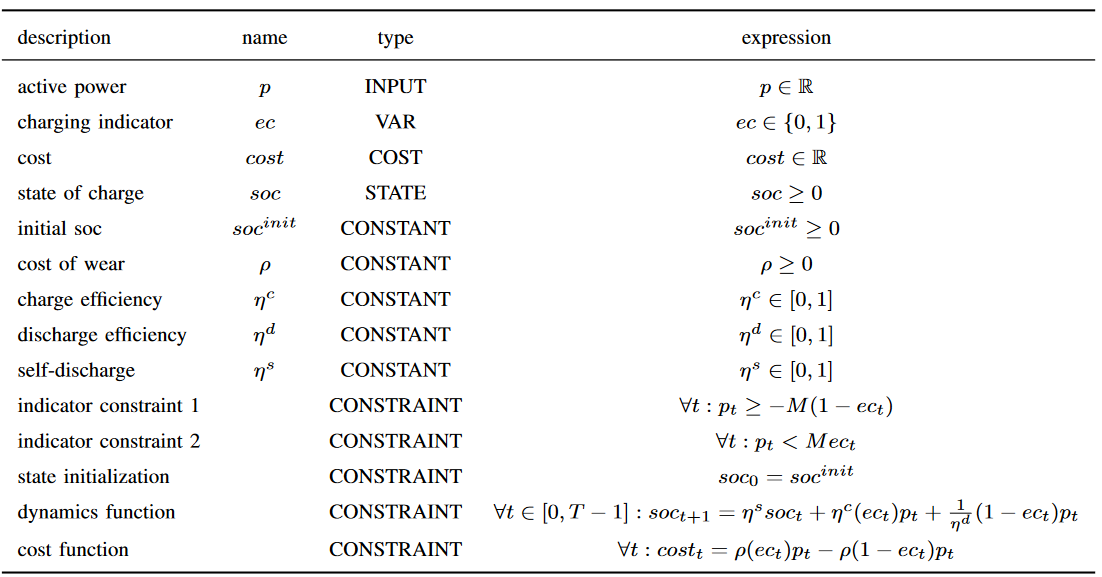

Most of this is hidden from the user of the component, they only have to provide required variable bounds or constants' values. \
The `.info()` method provides a fast overview over which model elements require configuration.

In [2]:
ESS.info()


---- INFO: ESS ----

+----------+----------+------------------------------------------+------------------+------------+------------------------------+---------------+
| Element  |   Type   |               Description                |      Domain      |   Bounds   |       Required config        | Data provider |
+----------+----------+------------------------------------------+------------------+------------+------------------------------+---------------+
|    p     |  INPUT   |               active power               |      Reals       |    None    |           [lb, ub]           |               |
|    q     |   VAR    |              reactive power              |      Reals       |    None    |           [lb, ub]           |               |
|   soc    |  STATE   |        state of charge (absolute)        | NonNegativeReals |    None    |           [lb, ub]           |               |
|   rho    | CONSTANT |             cost of wear pu              | NonNegativeReals |    None    | con

If you have a look at the code and specifically the `._get_model_elements()` method of the `ESS` class, you will find that `soc_init` and `cost` are not defined. \
This is because the `Node` parent class defines an augmentation method which adds an init parameter for every defined state variable and one cost variable. \
The indicatior variables and indicatior constraints are defined in the `._get_additional_constraints()` method to keep `._get_model_elements()` clean.

The ESS dynamics function is piecewise linear due to charge/discharge efficiencies. CommonPower takes the general approach to model such piecewise linear elements as mixed integer constraints. \
To this end, the `MIPExpressionBuilder` utility has been created. It provides a convenient interface (based on the Big-M approach) to generate binary indicator variables. \
In case of the ESS, we define an indicator variables which is 1 if the ESS is charging and 0 otherwise. With the expression builder we simply write `expbuilder.from_geq("p", 0, "p_ec")`. \
This generates a binary variable `p_ec` and the two indicator constraints you can see above. They make sure that `p_ec == 1` iff `p >= 0`. We can then use `p_ec` in the dynamics function.


## A new ESS model

As an example, we now want to adjust the ESS dynamics such that the charging efficiency is 30% lower if the stage of charge (soc) is above 80%. \
To this end, we first have to create a variable to track the relative state of charge, then define an additional indicator constraint which is active if `soc >= 0.8 * <soc upper bound>`, and finally adjust the dynamic function accordingly.

In [3]:
def NewESS(ESS):
    
    CLASS_INDEX = "new_ev"

    def _get_additional_constraints(self) -> List[ModelElement]:

        soc_rel = ModelElement(
            "soc_rel",
            et.VAR,
            "relative state of charge",
            bounds=[0, 1],  # if we define this here, the user will not be asked to provide bounds.
            domain=pyo.NonNegativeReals,
        )
        
        c_soc_rel = ModelElement(
            "c_soc_rel",
            et.CONSTRAINT,
            "constraint to track the relative soc",
            expr=lambda model, t: self.get_pyomo_element("soc_rel", model)[t] == self.get_pyomo_element("soc", model)[t] / self.get_pyomo_element("soc", model)[t].ub
        )
        
        mb = MIPExpressionBuilder(self)

        mb.from_geq("p", 0, "p_ec")
        
        mb.from_geq("soc_rel", 0.8, "soc80")

        return [soc_rel, c_soc_rel] + mb.model_elements  # the order here is important, as the elements are added to the pyomo model in this order
    
    def _get_dynamic_fcn(self) -> List[ModelElement]:
        def dynamic_fcn(model, t):
            # p > 0 is charging
            if t == self.horizon:  # horizon+1 cannot have a constraint
                return Constraint.Skip
            else:
                return (
                    self.get_pyomo_element("etas", model) * self.get_pyomo_element("soc", model)[t] * self.tau  # self-discharge
                ) + ( 
                    #self.get_pyomo_element("etac", model)
                    (
                        self.get_pyomo_element("soc80") * 0.7 * self.get_pyomo_element("etac", model)  # if soc>=80% -> etac*0.7
                        + (1 - self.get_pyomo_element("soc80")) * self.get_pyomo_element("etac", model) # otherwise as before
                    )
                    * self.get_pyomo_element("p", model)[t]
                    * self.get_pyomo_element("p_ec", model)[t]
                    * self.tau
                ) + (
                    (1 / self.get_pyomo_element("etad", model))
                    * self.get_pyomo_element("p", model)[t]
                    * (1 - self.get_pyomo_element("p_ec", model)[t])
                    * self.tau
                ) == self.get_pyomo_element("soc", model)[t + 1]

        dyn = ModelElement("dynamic_fcn", et.CONSTRAINT, "dynamic function", expr=dynamic_fcn)

        return [dyn]

Let's say we additionally want to impose a penalty factor on the cost function to account for the increased wear of the ESS when the soc is very large. \
For example, we can integrate a penalty multiplier of 1.2 as

In [4]:
def NewestESS(NewESS):
    
    def cost_fcn(self, model: ConcreteModel, t: int = 0) -> Expression:
            """
            The cost represents: cost = abs(p) * rho with an additional penalty factor of 1.2 if soc>=80%
            """
            return (
                (
                    self.get_pyomo_element("p", model)[t] * (self.get_pyomo_element("p_ec", model)[t])
                    - self.get_pyomo_element("p", model)[t] * (1 - self.get_pyomo_element("p_ec", model)[t])
                )
                * (
                    self.get_pyomo_element("soc80") * 1.2 * self.get_pyomo_element("rho", model)
                    + (1 - self.get_pyomo_element("soc80")) * self.get_pyomo_element("rho", model)
                )
                * self.tau
            )


## Some notes

For Components and Busses, the `Node` class also exposes an `._additional_updates()` method. \
This method is called on each time step and is not included in the pyomo model. \
It can be used to "secretly" update variables, e.g. when tracking a local time stamp or simulating uncertain dynamics.

CommonPower's MIP approach is quite flexible and allows modelling a large varieties of entities. \
The use of indicator constraints generally produces quadratically constrained optimization problems, and often MIQCQPs. \
However, as most of the quadratic constraints are binary, our experience is that the resulting optimization problems can be solved reasonably fast. \
See the MIP tutorial for more information on this.